In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook
import os, os.path

In [3]:
datasets = ['Biker', 'football']
# points with template roi. I get them from dataset file
roi_s = {
    'football': ((300,100),(60,60)),
    'Biker': ((262, 94), (16, 26)),
}

In [5]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 1,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (20,20),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

Dataset Biker loaded!


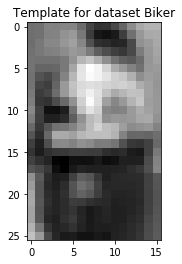

Dataset football loaded!


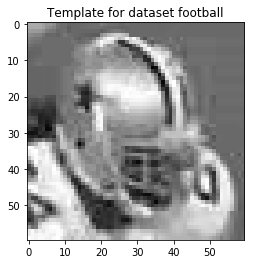

In [4]:
for dataset in datasets:
    img_l = len([name for name in os.listdir(f'./datasets/{dataset}/img')])
    images = [cv2.imread(f"./datasets/{dataset}/img/{str(i).zfill(4)}.jpg", 0) for i in range(1,img_l+1)]
    print(f"Dataset {dataset} loaded!")
    
    () = roi_s[dataset]
    # get template image for dataset
    template = images[0][roi[0][1]:roi[0][1]+roi[1][1], roi[0][0]:roi[0][0] + roi[1][0]]
    t_h, t_w = template.shape
    
    plt.title(f"Template for dataset {dataset}")
    plt.imshow(template, cmap='gray')
    plt.show()
    
    prev, *images = images
    mask = 
    prev_points = cv2.goodFeaturesToTrack(prev, mask = template, **feature_params)
    
    for img in images:
        p1, st, err = cv2.calcOpticalFlowPyrLK(prev, img, p0, None, **lk_params)
    
        good_new = p1[st==1]
        good_old = p0[st==1]
        if len(good_new) == 0:
            print("Flow was lost, trying to recover")
            mask_roi = np.zeros_like(old_gray)
            mask_roi[y_old:y_old+h, x_old:x_old+w] = 1
            p0 = cv2.goodFeaturesToTrack(frame_gray, mask = mask_roi, **feature_params)
            if p0 is None:
                print("Sorry, optical flow was lost. Recovery was unsuccessful, terminating.")
                break

            p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

            if len(p0[st==1]) == 0:
                print("Sorry, optical flow was lost. Recovery was unsuccessful, terminating.")
                break

        deltas = np.mean(good_new-good_old, axis=0)
        if i % 2 == 0:
            deltas = np.floor(deltas)
        else:
            deltas = np.ceil(deltas)

        dx = int(deltas[0])
        dy = int(deltas[1])


        '''
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        img2 = cv2.add(frame,mask)
        cv2.imshow('frame',img2)
        '''




        x_new = x_old + dx
        y_new = y_old + dy

        if x_new > im_w or x_new < - w or y_new > im_h or y_new < -h:
            print("Sorry, optical flow was lost or tracking object left camera vision space.")
            break

        img2 = cv2.rectangle(frame, (x_new, y_new), (x_new + w, y_new + h), (255, 0,0), 2)
        cv2.imshow('frame',img2)


        k = cv2.waitKey(0) & 0xff
        if k == 27:
            break

        # Now update the previous frame and previous points


        old_gray = frame_gray.copy()
        x_old, y_old = x_new, y_new
        p0 = good_new.reshape(-1,1,2)

In [6]:
a = [1,2,3]

In [10]:
f, *a = a

print(f)
print(a)

2
[3]
